In [209]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(keras.__version__)

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

2.5.0
2.5.0


In [210]:
#GPU 사용 설정, -1이면 CPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [211]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], 
#                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
# #     tf.config.experimental.set_virtual_device_configuration(gpus[1], 
# #                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

# 필요한 데이터 로드, split

In [212]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [213]:
fi = pd.read_csv('./data/df_all_best_type.csv')

In [214]:
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# Model

In [7]:
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

In [185]:
rf_feature = [51277, 50912, 51006, 63323026201, 50862, 50983, 51003, 51275, 904224461, 50882]
m1_feature = [55390012210, 536479301, 536376701, 536185097, 55390013910, 55390014301, 527155201, 2704001, 517420125, 575022530]

# Base predict

In [186]:
base_pred = model.predict(X_test)
base_pred

array([[0.9347042 ],
       [0.93680954],
       [0.92200565],
       ...,
       [0.93177086],
       [0.94601846],
       [0.9352856 ]], dtype=float32)

In [187]:
df = pd.DataFrame(base_pred, columns=['base_pred'])

In [188]:
df

,base_pred
0,0.934704
1,0.936810
2,0.922006
3,0.952133
4,0.952706
...,...
1540,0.908010
1541,0.151032
1542,0.931771
1543,0.946018


<AxesSubplot:ylabel='base_pred'>

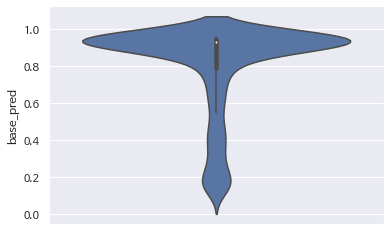

In [189]:
sns.violinplot(data=df, y='base_pred')

In [190]:
m1_index = [COLS.index(i) for i in m1_feature]

In [219]:
def draw_violinplot(item_list):
    idx_list = [COLS.index(i) for i in item_list]
    ax_num = 0
    plt.figure(figsize = (13,12), dpi=150)
    for i in tqdm(idx_list):
        
        base_pred = model.predict(X_test)
        df = pd.DataFrame(base_pred, columns=['base_pred'])
        
        save_cols = X_test[:,:,i].copy()
        #Change all values to 1
        X_test[:,:,i] = 1
        #Predict
        pred = model.predict(X_test)
        #Result
        one_result = pred.flatten()
        #값 복원
        X_test[:,:,i] = save_cols

        #Change all values to 0
        X_test[:,:,i] = 0
        #Predict
        pred = model.predict(X_test)
        #Result
        zero_result = pred.flatten()
        #값 복원
        X_test[:,:,i] = save_cols

        #Change all values inverse (0->1, 1->0)
        X_test[:,:,i] = abs(X_test[:,:,i]-1)
        #Predict
        pred = model.predict(X_test)
        #Result
        inverse_result = pred.flatten()
        #값 복원
        X_test[:,:,i] = save_cols

        df['0to1_pred'] = one_result
        df['1to0_pred'] = zero_result
        df['inverse_result'] = inverse_result
        
        plt.subplot(len(item_list)%3 + 3,3,1+ax_num)
        ax = sns.violinplot(data = [df['base_pred'].values,
                                   df['0to1_pred'].values,
                                   df['1to0_pred'].values,
                                   df['inverse_result'].values,], inner="quartile")
        _=ax.set_xticklabels(['base_pred','0to1_pred','1to0_pred', 'inverse_result'])
        _=ax.set_title(COLS[i], fontsize=14)
        ax_num+=1
    plt.tight_layout()

  0%|          | 0/10 [00:00<?, ?it/s]

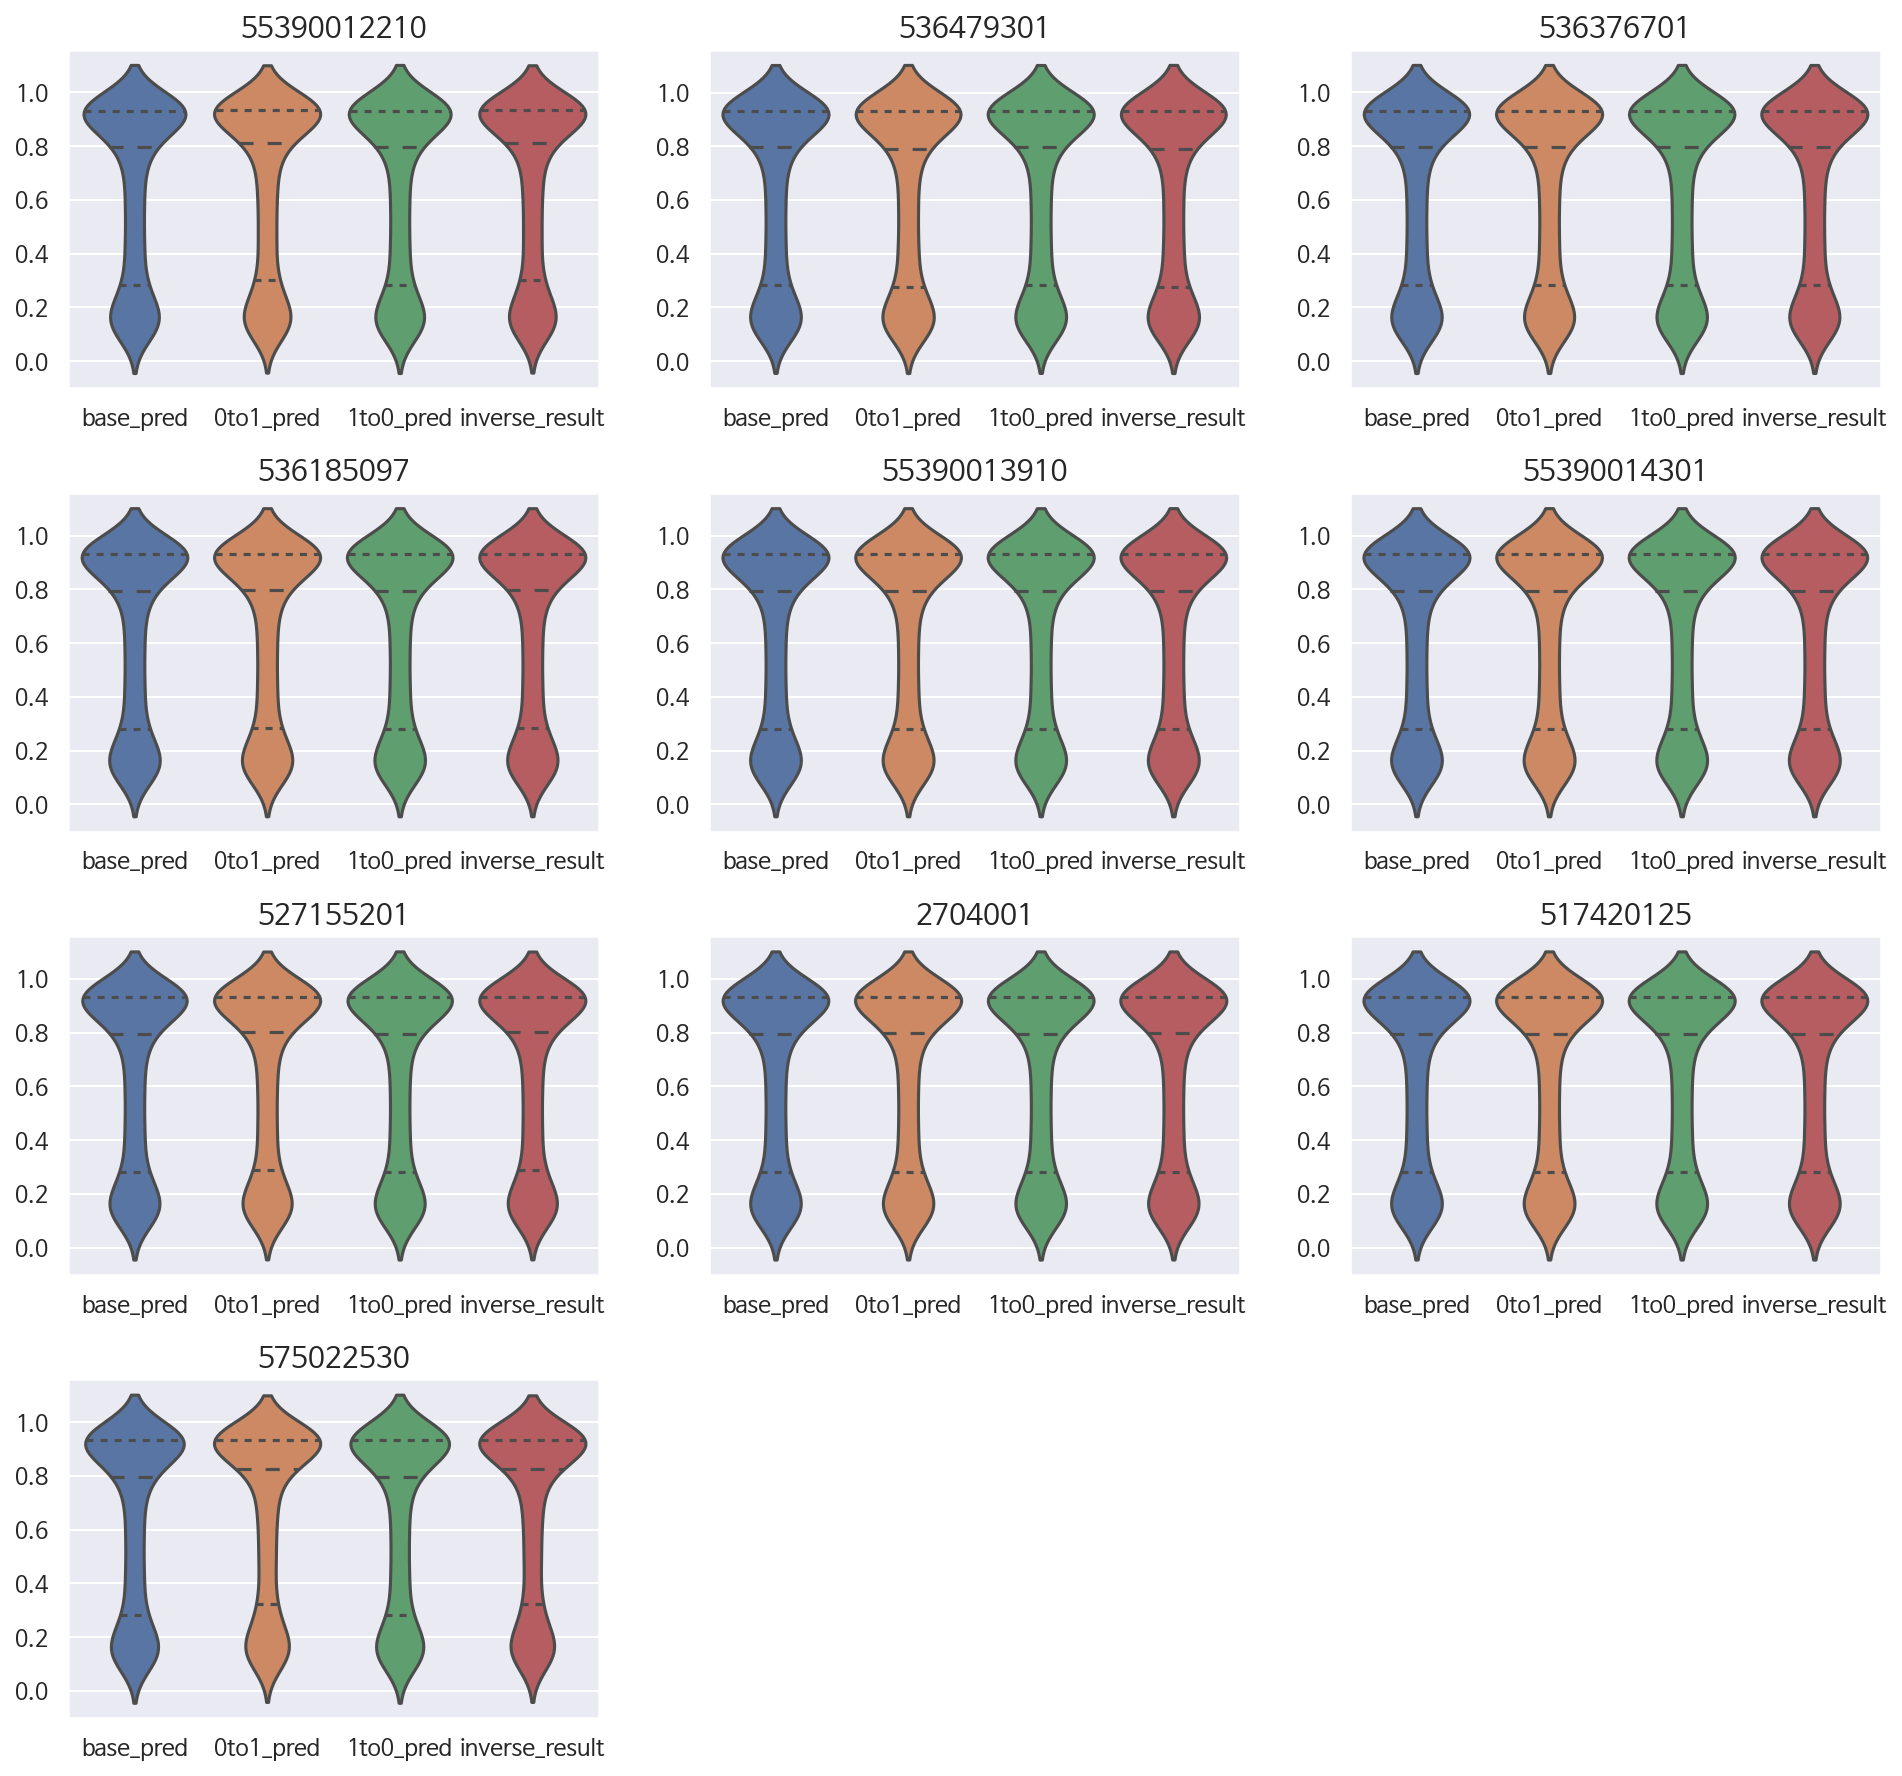

In [220]:
draw_violinplot(m1_feature)

  0%|          | 0/10 [00:00<?, ?it/s]

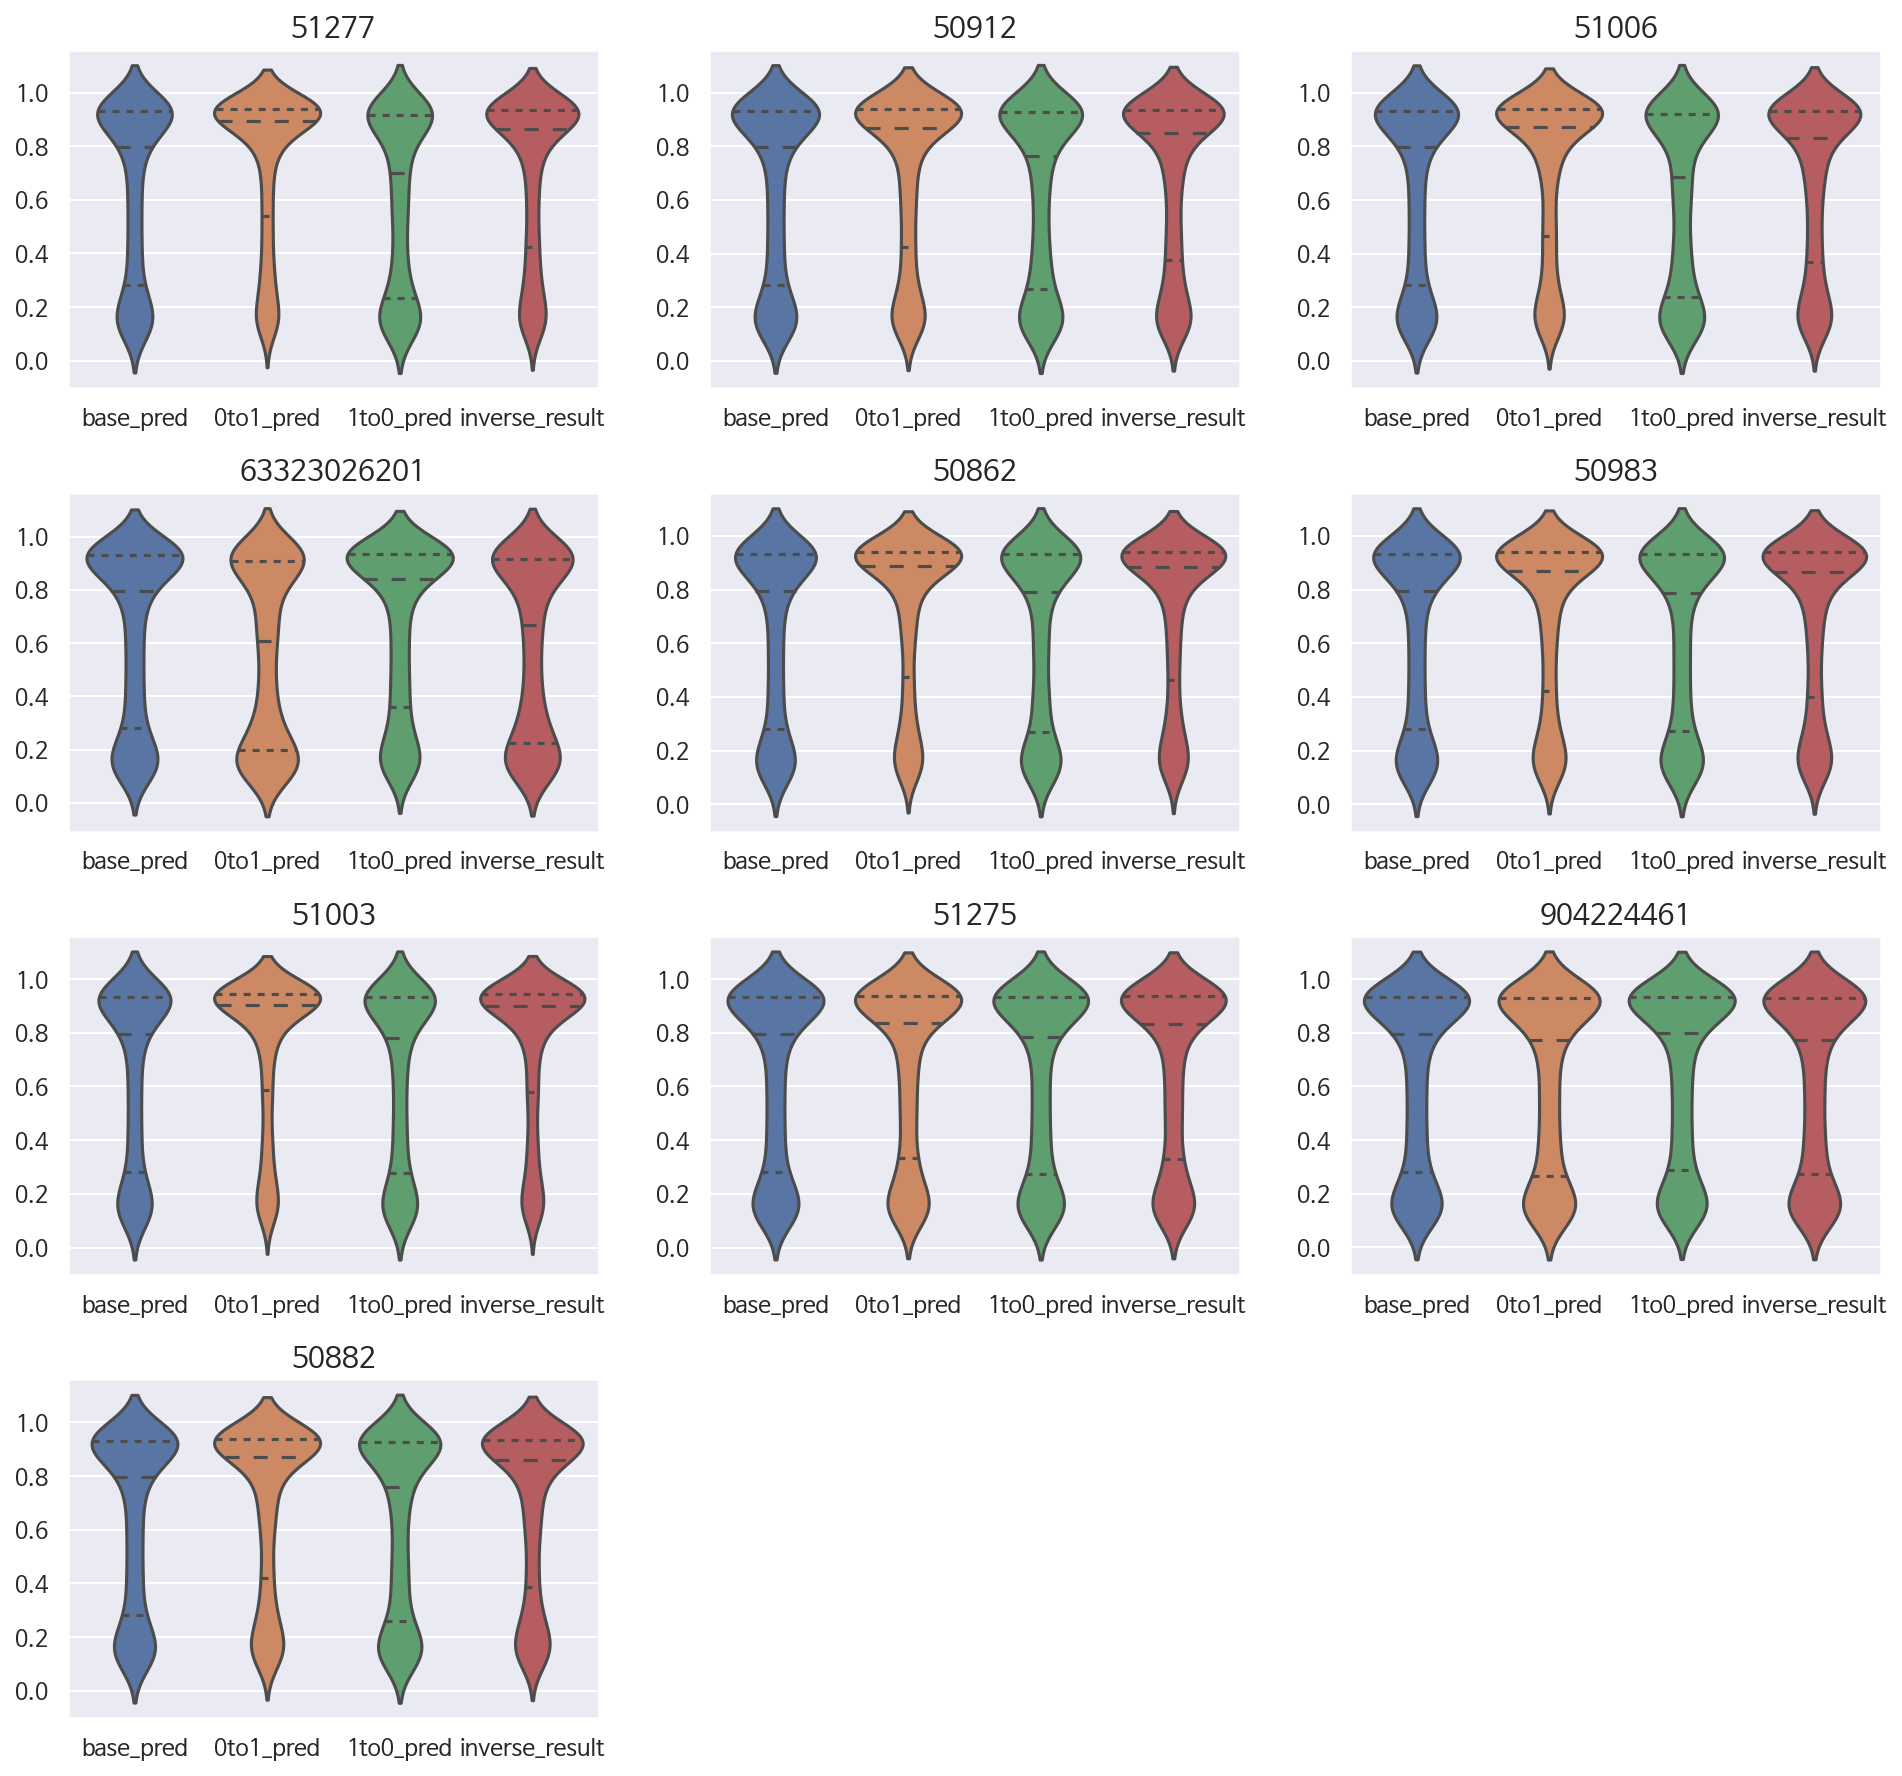

In [221]:
draw_violinplot(rf_feature)

In [222]:
df

,base_pred,0to1_pred,1to0_pred,inverse_result
0,0.857677,0.883958,0.801580,0.846044
1,0.881658,0.914967,0.881658,0.914967
2,0.816095,0.876550,0.811986,0.874460
3,0.948484,0.948647,0.945582,0.945834
4,0.950073,0.951214,0.949721,0.950961
...,...,...,...,...
1540,0.702797,0.802778,0.659503,0.774000
1541,0.113465,0.122060,0.113465,0.122060
1542,0.841742,0.886418,0.811812,0.870149
1543,0.924181,0.932647,0.913484,0.925535
